# Evaluación de posibles relaciones de covariables con regularización

En este se evalúa la relación de parámetros individuales frente a covariables

In [1]:
import pandas            as pd
import numpy             as np
import os
import statsmodels.api   as sm
import seaborn           as sns
import matplotlib.pyplot as plt
from itertools           import *
from sklearn.linear_model    import ElasticNet
from sklearn.model_selection import GridSearchCV

sns.set_theme(style='whitegrid')
plt.style.use('seaborn-whitegrid')

# 1. Introducción

In [2]:
df1 = pd.read_csv('../data/processed/001_parametrosIndividuales.csv')
df2 = pd.read_csv('../data/processed/002_etas.csv')

In [3]:
df2

,ID,AGEA,SEXF,WTKG,HCM,SCRMGDL,ALBGDL,PROGDL,CLCRMLMIN,RAL,RAN,ANTU,eta_Cl_SAEM,eta_V1_SAEM,eta_Q_SAEM,eta_V2_SAEM
0,1,79,0,57,155,0.77,3.08,6.6,97.5,710,90,2,-0.658734,-0.273836,0.186137,-0.362256
1,2,43,0,82,175,0.69,2.80,5.7,125.1,1470,310,2,0.231904,0.178957,-0.230945,0.237736
2,3,50,1,60,157,0.37,3.00,4.7,184.9,6520,120,2,0.187218,0.195715,-0.042216,0.262753
3,4,33,0,62,164,0.68,2.51,4.5,134.3,650,390,2,-0.013664,-0.306875,0.283039,-0.410447
4,5,53,1,67,162,0.62,3.74,7.1,100.7,990,490,1,-0.122764,0.076915,0.359904,0.102850
5,6,66,0,61,165,0.58,2.48,3.8,140.2,450,200,2,0.137061,0.439148,0.842145,0.583578
6,7,24,1,57,157,0.42,3.13,5.5,185.4,1120,310,2,0.110610,-0.542634,-0.768402,-0.721677
7,8,20,0,84,181,0.53,3.98,6.5,198.2,840,360,1,0.247493,0.023719,-0.160997,0.030580
8,9,60,0,67,167,0.74,3.65,6.2,107.9,180,120,1,-0.049875,-0.026107,0.363166,-0.033367
9,10,25,1,52,160,0.58,3.19,5.2,126.7,930,430,2,-0.414205,-0.253628,-0.411286,-0.339983


In [5]:
covariables = ['AGEA', 'SEXF', 'WTKG', 'HCM', 'SCRMGDL', 'ALBGDL', 'PROGDL', 'CLCRMLMIN', 'RAL', 'RAN', 'ANTU']

train_mean = df2.loc[:, covariables].mean()
train_std =  df2.loc[:, covariables].std()

train_df2 = (df2.loc[:, covariables] - train_mean)/train_std
train_df2

,AGEA,SEXF,WTKG,HCM,SCRMGDL,ALBGDL,PROGDL,CLCRMLMIN,RAL,RAN,ANTU
0,1.942600,-0.834523,-0.502729,-1.120892,1.339642,-0.083807,1.103476,-1.350696,-0.434755,-1.308753,0.503236
1,-0.055503,-0.834523,1.975512,1.410154,0.769148,-0.650224,0.117391,-0.547512,0.000000,0.343279,0.503236
2,0.333017,1.112697,-0.205340,-0.867787,-1.512827,-0.245640,-0.978259,1.192720,2.888832,-1.083476,0.503236
3,-0.610532,-0.834523,-0.007081,0.018079,0.697836,-1.236871,-1.197389,-0.279784,-0.469078,0.944018,0.503236
4,0.499526,1.112697,0.488567,-0.235026,0.269966,1.251320,1.651301,-1.257573,-0.274582,1.694942,-1.845200
5,1.221063,-0.834523,-0.106210,0.144631,-0.015281,-1.297559,-1.964344,-0.108089,-0.583487,-0.482737,0.503236
6,-1.110057,1.112697,-0.502729,-0.867787,-1.156269,0.017339,-0.101739,1.207270,-0.200216,0.343279,0.503236
7,-1.332069,-0.834523,2.173771,2.169468,-0.371840,1.736821,0.993911,1.579761,-0.360389,0.718741,-1.845200
8,0.888046,-0.834523,0.488567,0.397736,1.125706,1.069258,0.665216,-1.048047,-0.737939,-1.083476,-1.845200
9,-1.054555,1.112697,-0.998377,-0.488130,-0.015281,0.138715,-0.430434,-0.500951,-0.308905,1.244388,0.503236


## 1. Modelos de Regresión Lineal

In [6]:
model_eta_Cl = sm.OLS(df2.eta_Cl_SAEM, sm.add_constant(train_df2))
model_eta_Q  = sm.OLS(df2.eta_Q_SAEM, sm.add_constant(train_df2))
model_eta_V1 = sm.OLS(df2.eta_V1_SAEM, sm.add_constant(train_df2))
model_eta_V2 = sm.OLS(df2.eta_V2_SAEM, sm.add_constant(train_df2))

In [7]:
model_eta_Cl.fit().summary()

c:\users\daniel\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=14
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            eta_Cl_SAEM   R-squared:                       0.716
Model:                            OLS   Adj. R-squared:                 -0.847
Method:                 Least Squares   F-statistic:                    0.4582
Date:                Fri, 05 Feb 2021   Prob (F-statistic):              0.841
Time:                        20:32:24   Log-Likelihood:                 8.3420
No. Observations:                  14   AIC:                             7.316
Df Residuals:                       2   BIC:                             14.98
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002      0.094      0.002      0.999      -0.406       0.406
AGEA          -0.4169      0.504     -0.827      0.495      -2.585       1.751
SEXF          -0.5990      1.102     -0.544      0.641      -5.339       4.141
WTKG           0.1727      0.189      0.912      0.458      -0.642       0.987
HCM           -0.0461      0.362     -0.127      0.910      -1.603       1.511
SCRMGDL       -1.1405      1.442     -0.791      0.512      -7.346       5.065
ALBGDL         0.1354      0.350      0.387      0.736      -1.371       1.642
PROGDL        -0.0310      0.212     -0.146      0.897      -0.944       0.882
CLCRMLMIN     -0.8745      1.152     -0.759      0.527      -5.831       4.082
RAL            0.0486      0.220      0.221      0.846      -0.899       0.996
RAN           -0.1605      0.198     -0.811      0.502      -1.012       0.691
ANTU           0.0553      0.214      0.259      0.820      -0.865       0.975
==============================================================================
Omnibus:                        4.257   Durbin-Watson:                   1.671
Prob(Omnibus):                  0.119   Jarque-Bera (JB):                1.824
Skew:                          -0.818   Prob(JB):                        0.402
Kurtosis:                       3.672   Cond. No.                         43.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [8]:
model_eta_Q.fit().summary()

c:\users\daniel\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=14
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             eta_Q_SAEM   R-squared:                       0.994
Model:                            OLS   Adj. R-squared:                  0.960
Method:                 Least Squares   F-statistic:                     29.15
Date:                Fri, 05 Feb 2021   Prob (F-statistic):             0.0336
Time:                        20:32:24   Log-Likelihood:                 24.927
No. Observations:                  14   AIC:                            -25.85
Df Residuals:                       2   BIC:                            -18.18
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0036      0.029      0.125      0.912      -0.120       0.128
AGEA           0.0815      0.154      0.528      0.650      -0.582       0.745
SEXF          -1.1254      0.337     -3.340      0.079      -2.575       0.324
WTKG          -0.2276      0.058     -3.929      0.059      -0.477       0.022
HCM           -0.1155      0.111     -1.043      0.406      -0.592       0.361
SCRMGDL       -1.3689      0.441     -3.103      0.090      -3.267       0.529
ALBGDL        -0.1305      0.107     -1.219      0.347      -0.591       0.330
PROGDL         0.0332      0.065      0.511      0.660      -0.246       0.312
CLCRMLMIN     -0.8764      0.352     -2.487      0.131      -2.393       0.640
RAL            0.1606      0.067      2.383      0.140      -0.129       0.450
RAN            0.2692      0.061      4.450      0.047       0.009       0.530
ANTU          -0.3531      0.065     -5.400      0.033      -0.634      -0.072
==============================================================================
Omnibus:                        4.808   Durbin-Watson:                   1.826
Prob(Omnibus):                  0.090   Jarque-Bera (JB):                2.188
Skew:                           0.901   Prob(JB):                        0.335
Kurtosis:                       3.707   Cond. No.                         43.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [9]:
model_eta_V1.fit().summary()

c:\users\daniel\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=14
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            eta_V1_SAEM   R-squared:                       0.716
Model:                            OLS   Adj. R-squared:                 -0.848
Method:                 Least Squares   F-statistic:                    0.4579
Date:                Fri, 05 Feb 2021   Prob (F-statistic):              0.841
Time:                        20:32:24   Log-Likelihood:                 8.4076
No. Observations:                  14   AIC:                             7.185
Df Residuals:                       2   BIC:                             14.85
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -5.232e-05      0.094     -0.001      1.000      -0.404       0.404
AGEA          -0.2244      0.502     -0.447      0.698      -2.383       1.934
SEXF          -0.5116      1.096     -0.467      0.687      -5.229       4.206
WTKG          -0.0049      0.188     -0.026      0.981      -0.816       0.806
HCM            0.2110      0.360      0.586      0.617      -1.339       1.761
SCRMGDL       -1.1322      1.435     -0.789      0.513      -7.308       5.044
ALBGDL         0.1076      0.348      0.309      0.787      -1.392       1.607
PROGDL        -0.0275      0.211     -0.130      0.908      -0.936       0.881
CLCRMLMIN     -0.9752      1.147     -0.851      0.485      -5.909       3.958
RAL            0.0694      0.219      0.317      0.782      -0.874       1.013
RAN           -0.1837      0.197     -0.933      0.449      -1.031       0.663
ANTU           0.0413      0.213      0.194      0.864      -0.874       0.957
==============================================================================
Omnibus:                        0.510   Durbin-Watson:                   1.962
Prob(Omnibus):                  0.775   Jarque-Bera (JB):                0.537
Skew:                          -0.021   Prob(JB):                        0.765
Kurtosis:                       2.042   Cond. No.                         43.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [10]:
model_eta_V2.fit().summary()

c:\users\daniel\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=14
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            eta_V2_SAEM   R-squared:                       0.716
Model:                            OLS   Adj. R-squared:                 -0.847
Method:                 Least Squares   F-statistic:                    0.4580
Date:                Fri, 05 Feb 2021   Prob (F-statistic):              0.841
Time:                        20:32:24   Log-Likelihood:                 4.4046
No. Observations:                  14   AIC:                             15.19
Df Residuals:                       2   BIC:                             22.86
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0002      0.125     -0.001      0.999      -0.538       0.537
AGEA          -0.2963      0.668     -0.444      0.701      -3.169       2.576
SEXF          -0.6759      1.459     -0.463      0.689      -6.955       5.603
WTKG          -0.0062      0.251     -0.025      0.982      -1.086       1.073
HCM            0.2813      0.479      0.587      0.617      -1.782       2.344
SCRMGDL       -1.4998      1.911     -0.785      0.515      -9.720       6.721
ALBGDL         0.1424      0.464      0.307      0.788      -1.853       2.138
PROGDL        -0.0365      0.281     -0.130      0.908      -1.246       1.173
CLCRMLMIN     -1.2926      1.526     -0.847      0.486      -7.859       5.274
RAL            0.0925      0.292      0.317      0.781      -1.163       1.348
RAN           -0.2452      0.262     -0.936      0.448      -1.373       0.882
ANTU           0.0545      0.283      0.193      0.865      -1.164       1.273
==============================================================================
Omnibus:                        0.509   Durbin-Watson:                   1.959
Prob(Omnibus):                  0.775   Jarque-Bera (JB):                0.537
Skew:                          -0.019   Prob(JB):                        0.765
Kurtosis:                       2.042   Cond. No.                         43.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### 2.1. Gráficos de predicciones

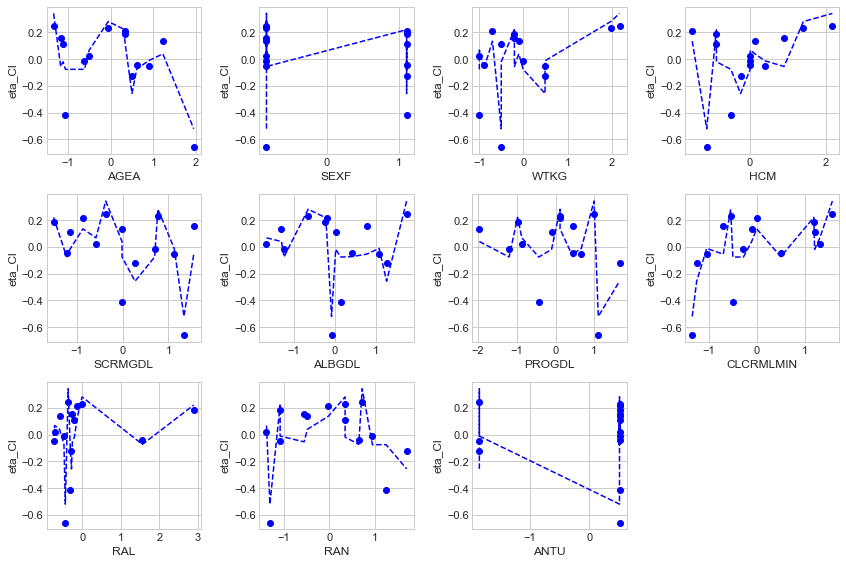

In [11]:
fig = plt.figure(figsize=(12,8))

for i, feature in enumerate(covariables):
    plt.subplot(3, 4, i+1)
    colvalues = train_df2[feature]
    plt.scatter(colvalues.values, df2.eta_Cl_SAEM, alpha = 1, edgecolor=None, color='blue')
    
    # Model prediction
    pred_df = pd.DataFrame({'x': colvalues.values, 'y': model_eta_Cl.fit().predict()}).sort_values(by = 'x')
    plt.plot(pred_df.x, pred_df.y, color='blue', linestyle='dashed')
    plt.xlabel(feature)
    plt.ylabel('eta_Cl')

fig.set_tight_layout(True);

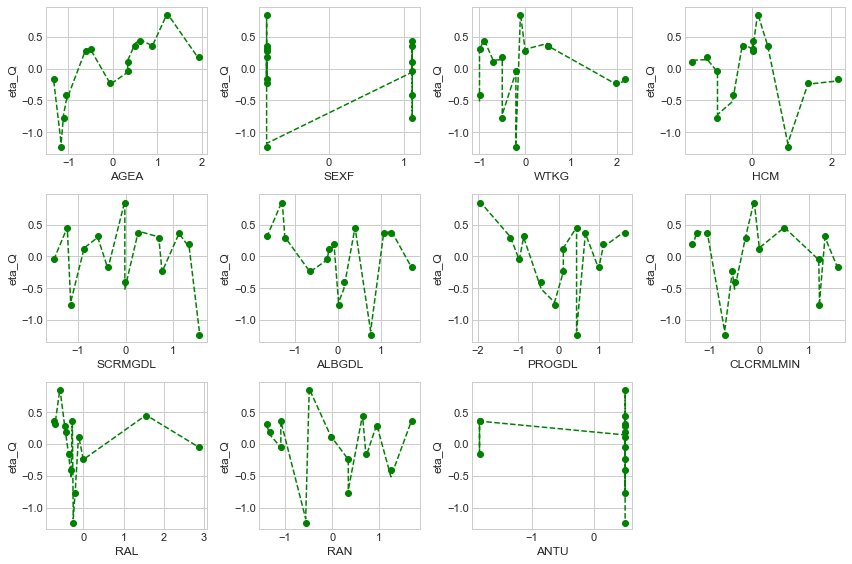

In [12]:
fig = plt.figure(figsize=(12,8))

for i, feature in enumerate(covariables):
    plt.subplot(3, 4, i+1)
    colvalues = train_df2[feature]
    plt.scatter(colvalues.values, df2.eta_Q_SAEM, alpha = 1, edgecolor=None, color='green')
    
    # Model prediction
    pred_df = pd.DataFrame({'x': colvalues.values, 'y': model_eta_Q.fit().predict()}).sort_values(by = 'x')
    plt.plot(pred_df.x, pred_df.y, color='green', linestyle='dashed')
    plt.xlabel(feature)
    plt.ylabel('eta_Q')

fig.set_tight_layout(True);

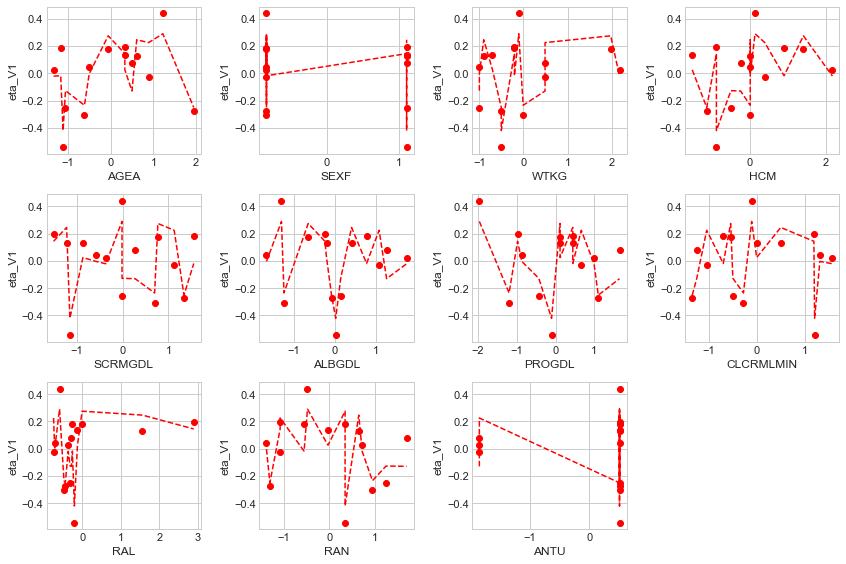

In [13]:
fig = plt.figure(figsize=(12,8))

for i, feature in enumerate(covariables):
    plt.subplot(3, 4, i+1)
    colvalues = train_df2[feature]
    plt.scatter(colvalues.values, df2.eta_V1_SAEM, alpha = 1, edgecolor=None, color='red')
    
    # Model prediction
    pred_df = pd.DataFrame({'x': colvalues.values, 'y': model_eta_V1.fit().predict()}).sort_values(by = 'x')
    plt.plot(pred_df.x, pred_df.y, color='red', linestyle='dashed')
    plt.xlabel(feature)
    plt.ylabel('eta_V1')

fig.set_tight_layout(True);

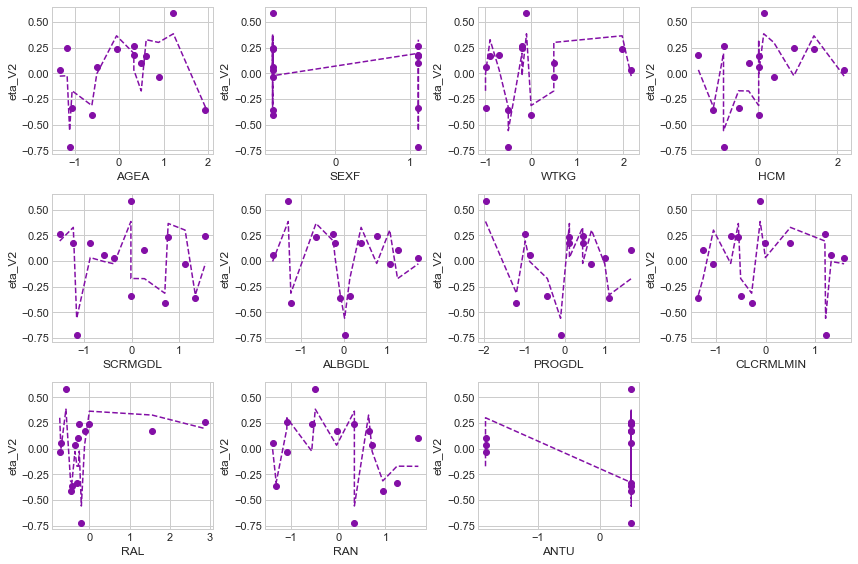

In [14]:
fig = plt.figure(figsize=(12,8))

for i, feature in enumerate(covariables):
    plt.subplot(3, 4, i+1)
    colvalues = train_df2[feature]
    plt.scatter(colvalues.values, df2.eta_V2_SAEM, alpha = 1, edgecolor=None, color='#830fa6')
    
    # Model prediction
    pred_df = pd.DataFrame({'x': colvalues.values, 'y': model_eta_V2.fit().predict()}).sort_values(by = 'x')
    plt.plot(pred_df.x, pred_df.y, color='#830fa6', linestyle='dashed')
    plt.xlabel(feature)
    plt.ylabel('eta_V2')

fig.set_tight_layout(True);

## 3. Modelo de Red Elástica 

In [35]:
# Definición de grilla de hiperparámetros
malla = dict()
malla['alpha']    = np.logspace(-7, 0, 30) 
malla['l1_ratio'] = np.linspace(0, 1, 30)

In [36]:
# Definición de Modelos
modeloRedElastica = ElasticNet(max_iter=1e5, fit_intercept=False)
busquedaGrid = GridSearchCV(modeloRedElastica, malla, scoring = 'r2', n_jobs=-1)

In [37]:
print('Eta Cl')
eNet_eta_Cl = busquedaGrid.fit(train_df2, df2.eta_Cl_SAEM)
print('Eta Q')
eNet_eta_Q  = busquedaGrid.fit(train_df2, df2.eta_Q_SAEM)
print('Eta V1')
eNet_eta_V1 = busquedaGrid.fit(train_df2, df2.eta_V1_SAEM)
print('Eta V2')
eNet_eta_V2 = busquedaGrid.fit(train_df2, df2.eta_V2_SAEM)

Eta Cl
Eta Q
Eta V1
Eta V2


In [38]:
[i for i in eNet_eta_Cl.cv_results_]

['mean_fit_time',
 'std_fit_time',
 'mean_score_time',
 'std_score_time',
 'param_alpha',
 'param_l1_ratio',
 'params',
 'split0_test_score',
 'split1_test_score',
 'split2_test_score',
 'split3_test_score',
 'split4_test_score',
 'mean_test_score',
 'std_test_score',
 'rank_test_score']

In [39]:
def gridModelos(gridSearch, title):
    
    best_pars = gridSearch.best_params_
    n1, n2 = [len(malla[i]) for i in malla]
    reshape_df1 = np.array([i for i in gridSearch.cv_results_['mean_test_score']]).reshape(n1, n2)
    reshape_df2 = np.array([i for i in gridSearch.cv_results_['std_test_score']]).reshape(n1, n2)
    
    def subPlotGrid(ax, reshape, title):
        cp1 = ax.contourf(malla['alpha'], malla['l1_ratio'], reshape, cmap='viridis')

        ax.scatter(best_pars['alpha'], best_pars['l1_ratio'], 
                   marker='x', alpha=1, color='red')
        
        plt.colorbar(cp1)
        
        ax.set(xscale = 'log', xlabel=r'$\lambda_1$', ylabel=r'$\lambda_2$', title=title);
    
    fig = plt.figure(figsize=(12,5))
    ax1 = plt.subplot(121)
    subPlotGrid(ax1, reshape_df1, 'Mean Test Score')
    ax2 = plt.subplot(122)
    subPlotGrid(ax2, reshape_df2, 'Std Test Score')
    plt.suptitle(title)

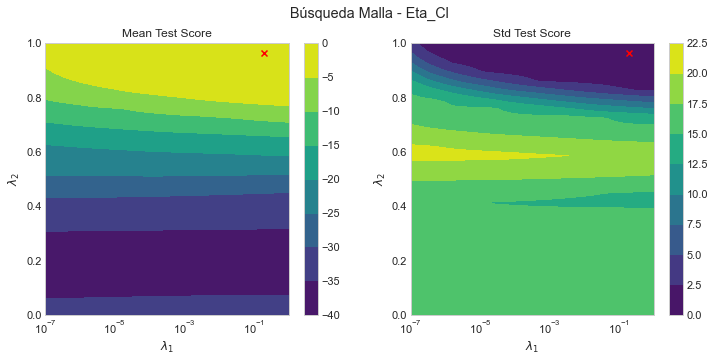

In [40]:
gridModelos(eNet_eta_Cl, 'Búsqueda Malla - Eta_Cl')
plt.savefig('../figures/011_ENet_eta_Cl.pdf')

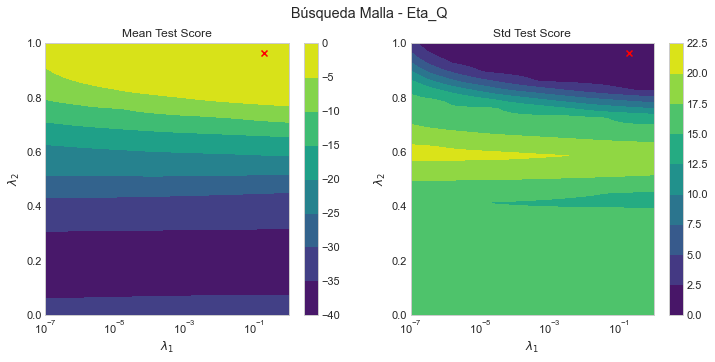

In [41]:
gridModelos(eNet_eta_Q, 'Búsqueda Malla - Eta_Q')
plt.savefig('../figures/012_ENet_eta_Q.pdf')

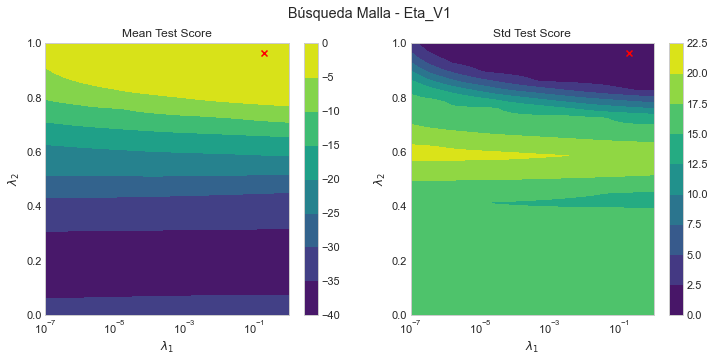

In [42]:
gridModelos(eNet_eta_V1, 'Búsqueda Malla - Eta_V1')
plt.savefig('../figures/013_ENet_eta_V1.pdf')

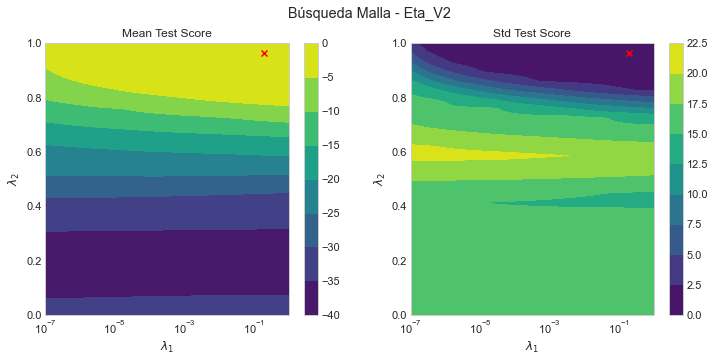

In [43]:
gridModelos(eNet_eta_V2, 'Búsqueda Malla - Eta_V2')
plt.savefig('../figures/014_ENet_eta_V2.pdf')

In [44]:
eNet_eta_Cl.best_estimator_.get_params()

{'alpha': 0.18873918221350997,
 'copy_X': True,
 'fit_intercept': False,
 'l1_ratio': 0.9655172413793103,
 'max_iter': 100000.0,
 'normalize': False,
 'positive': False,
 'precompute': False,
 'random_state': None,
 'selection': 'cyclic',
 'tol': 0.0001,
 'warm_start': False}

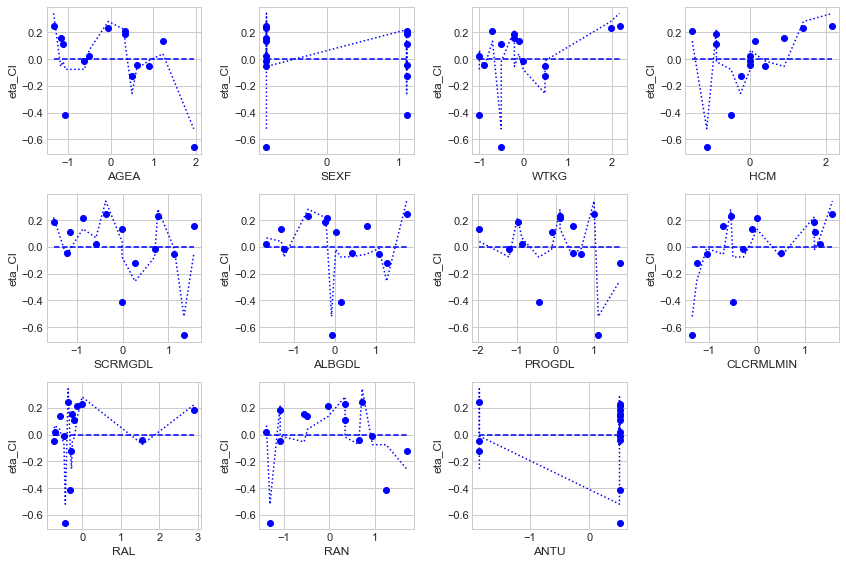

In [45]:
fig = plt.figure(figsize=(12,8))

for i, feature in enumerate(covariables):
    plt.subplot(3, 4, i+1)
    colvalues = train_df2[feature]
    plt.scatter(colvalues.values, df2.eta_Cl_SAEM, alpha = 1, edgecolor=None, color='blue')
    
    # Model prediction
    pred_df = pd.DataFrame({
        'x': colvalues.values, 
        'y1': eNet_eta_Cl.best_estimator_.predict(train_df2),
        'y2': model_eta_Cl.fit().predict()
    }).sort_values(by = 'x')
    
    plt.plot(pred_df.x, pred_df.y1, color='blue', linestyle='dashed')
    plt.plot(pred_df.x, pred_df.y2, color='blue', linestyle='dotted')
    
    plt.xlabel(feature)
    plt.ylabel('eta_Cl')

fig.set_tight_layout(True);

In [46]:
# list(chain(['In'], train_df2.columns.values))
eNet_eta_Cl.best_estimator_.max_iter

100000.0

In [47]:
def graficoImportancia(model, columnNames, intercepts: 'Bool', ax, color='blue', title = ''):
    
    if intercepts:
        yLabels = list(chain(['In'], columnNames))
    else:
        yLabels = columnNames
    
    df = pd.DataFrame({
        'Parameters': columnNames,
        'p_value':    model.coef_})\
    .reset_index()
    
    ax.barh(df.Parameters, df.p_value, align='center', 
            edgecolor='black', color = 'b', alpha=0.5)
    ax.set_title(title)
    ax.set_xlabel('p-value')

# model_ElasticNet\
# .sort_values(by=['p_val'], ascending=False)\
# .plot.barh(x='Parameters', y='p_val', ylabel='Valor Coeficiente', xlabel='');


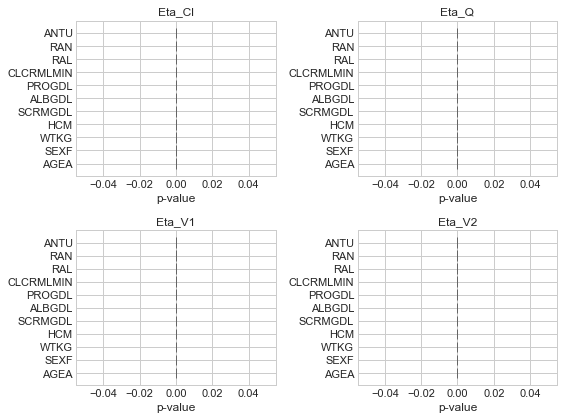

In [48]:
fig = plt.figure(figsize=(8,6))

ax1 = plt.subplot(221)
graficoImportancia(eNet_eta_Cl.best_estimator_, train_df2.columns.values, False, ax1, title = 'Eta_Cl')
ax2 = plt.subplot(222)
graficoImportancia(eNet_eta_Q.best_estimator_, train_df2.columns.values, False, ax2, title = 'Eta_Q')
ax3 = plt.subplot(223)
graficoImportancia(eNet_eta_V1.best_estimator_, train_df2.columns.values, False, ax3, title = 'Eta_V1')
ax4 = plt.subplot(224)
graficoImportancia(eNet_eta_V2.best_estimator_, train_df2.columns.values, False, ax4, title = 'Eta_V2')

fig.set_tight_layout(True)
plt.savefig('../figures/015_coeficientesENet.pdf')

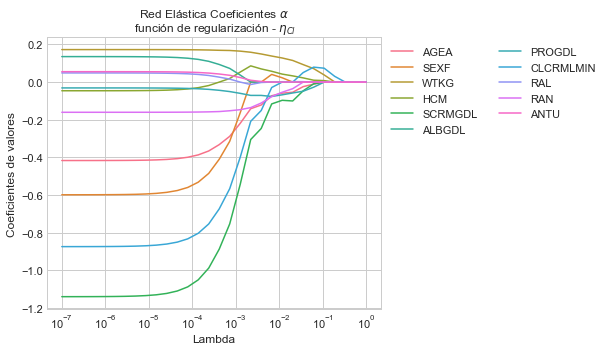

In [49]:
Coeff_list = []

for l in malla['alpha']:
    eNet = ElasticNet(alpha=l, fit_intercept=True, l1_ratio=0.52, max_iter=1e5)
    coeff = eNet.fit(train_df2, df2.eta_Cl_SAEM).coef_
    Coeff_list.append(coeff)

Coeff_df = pd.DataFrame(Coeff_list, 
             columns = train_df2.columns, 
             index=malla['alpha'])\
    .reset_index()\
    .melt(id_vars='index')\
    .rename(columns={'index':'Lambda'})

fig, ax = plt.subplots( figsize  = (6,5))
ax = sns.lineplot(x='Lambda', y='value', hue='variable', data=Coeff_df)
ax.set(xlabel='Lambda', ylabel='Coeficientes de valores', 
       title='Red Elástica Coeficientes $\\alpha$ \n función de regularización - $\\eta_{Cl}$')
ax.semilogx() #ax.set_xscale('log')
leg1 = plt.legend(loc='upper left', bbox_to_anchor=(1,1), ncol=2);
fig.savefig('../figures/016_SeguimientoCoeficientes.pdf', bbox_extra_artists=(leg1,), bbox_inches='tight')

In [54]:
def graficoFuncionRegularizacion(X, y, pars, ax, title, xlim=[1e-7, 1e+0], legend=False):
    coeffList = []
    lts_list = ['-', '--', '-.', ':', '-', '--', '-.', ':', '-', '--', '-.']

    for l in pars:
        eNet = ElasticNet(alpha=l, fit_intercept=True, l1_ratio=0.52, max_iter=1e5)
        coeff = eNet.fit(X, y).coef_
        coeffList.append(coeff)

    coeffDF = pd.DataFrame(coeffList, 
                 columns = X.columns, 
                 index = pars)\
        .reset_index()\
        .melt(id_vars='index')\
        .rename(columns={'index':'Lambda'})
    
    ax = sns.lineplot(x='Lambda', y='value', hue='variable', style= 'variable', data=coeffDF)
    
    ax.set(xlabel='Lambda', ylabel='Coeficientes de valores', xlim = xlim,
           title=title)
    
    ax.semilogx()
    
    if legend:
        leg1 = plt.legend(loc='upper left', bbox_to_anchor=(1,1), ncol=2)
    else:
        ax.get_legend().remove()

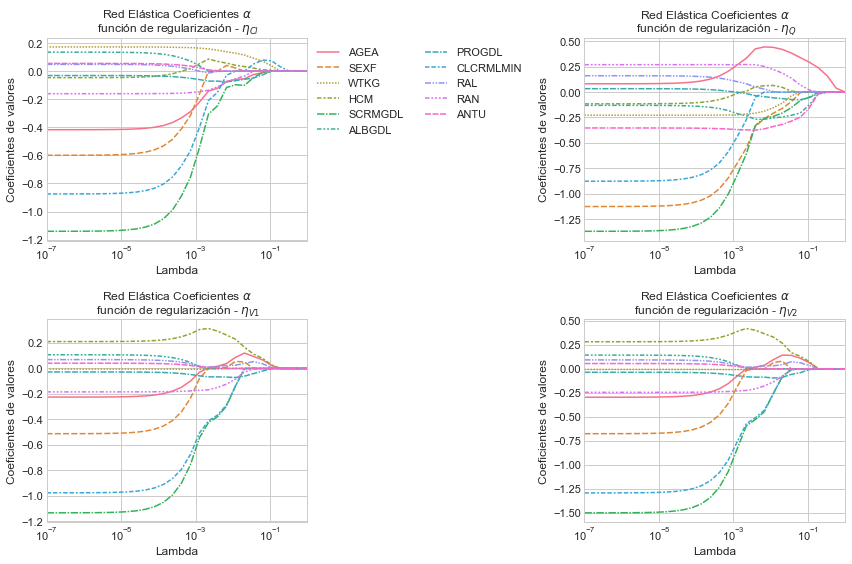

In [55]:
title1 = 'Red Elástica Coeficientes $\\alpha$ \n función de regularización - '

fig = plt.figure(figsize  = (12,8))
ax1 = plt.subplot(221)
graficoFuncionRegularizacion(train_df2, df2.eta_Cl_SAEM, malla['alpha'], ax1, ''.join([title1, '$\\eta_{Cl}$']), legend=True)
ax2 = plt.subplot(222)
graficoFuncionRegularizacion(train_df2, df2.eta_Q_SAEM,  malla['alpha'], ax2, ''.join([title1, '$\\eta_{Q}$']))
ax3 = plt.subplot(223)
graficoFuncionRegularizacion(train_df2, df2.eta_V1_SAEM, malla['alpha'], ax3, ''.join([title1, '$\\eta_{V1}$']))
ax4 = plt.subplot(224)
graficoFuncionRegularizacion(train_df2, df2.eta_V2_SAEM, malla['alpha'], ax4, ''.join([title1, '$\\eta_{V2}$']))
fig.set_tight_layout(True)

fig.savefig('../figures/017_SeguimientoCoeficientes_zoom.pdf', bbox_extra_artists=(leg1,), bbox_inches='tight')